In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !pip3 install python-mnist
# !wget https://github.com/sorki/python-mnist/blob/master/bin/mnist_get_data.sh
# !mnist_get_data.sh

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import time

import torch
import matplotlib.pylab as plt
from tqdm.notebook import tqdm, trange
import numpy as np
from scipy.spatial.distance import cdist
from mnist import MNIST
from IPython.display import clear_output
import cv2

# sys.path.append('/content/drive/MyDrive/Documents/OPTAMI/OPTAMI')
# sys.path.append('/content/drive/MyDrive/Documents/OPTAMI')
from OPTAMI import PrimalDualAccelerated, BDGM
from run_pd_experiment import *

In [3]:
# device = 'cuda:1'
device = 'cpu'

In [4]:
# A_A_T_path = 'A_A_T.pkl'
# if not os.path.exists(A_A_T_path):
#     A_matrix = calculate_A_matrix(n)
#     A_A_T = A_matrix @ A_matrix.T
#     torch.save(A_A_T, A_A_T_path)
# else:
#     A_A_T = torch.load(A_A_T_path)

# Preliminaries

## Data

In [5]:
gamma = 0.5
eps = 0.01
image_index = 2

new_m = 10

In [6]:
eps, gamma

(0.01, 0.5)

In [7]:
images, labels = load_data()
if new_m is not None:
    n = new_m ** 2
    m = new_m
else:
    n = len(images[0])
    m = int(np.sqrt(n))

p_list = [34860, 31226, 239, 37372, 17390]
q_list = [45815, 35817, 43981, 54698, 49947]

# x_array = np.linspace(1 / 2e-2, 1 / 4e-4, 6)
# epslist = 1 / x_array
epsp = eps / 8

p, q = mnist(epsp, p_list[image_index], q_list[image_index], images, m)
p = torch.tensor(p, device=device, dtype=torch.double)
q = torch.tensor(q, device=device, dtype=torch.double)

p_ref, q_ref = mnist(0, p_list[image_index], q_list[image_index], images, m)
p_ref = torch.tensor(p_ref, device=device, dtype=torch.double)
q_ref = torch.tensor(q_ref, device=device, dtype=torch.double)

b = torch.cat((p, q))

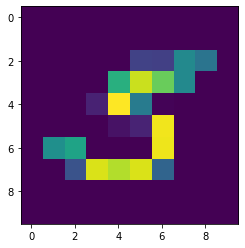

In [8]:
plt.imshow(p.reshape(m, m).cpu().numpy())

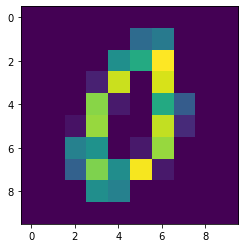

In [9]:
plt.imshow(q.reshape(m, m).cpu().numpy())

In [10]:
p.shape

torch.Size([100])

## Other 

In [11]:
M_matrix = calculate_M_matrix(m).to(device)

In [12]:
ones = torch.ones(n, device=device, dtype=torch.double)
primal_func = lambda x: f(x, M_matrix, gamma, device)
dual_func = lambda lamb: phi(lamb, n, gamma, M_matrix / gamma, ones, p, q)
primal_var_func = lambda lamb: calculate_x(lamb, n, gamma, M_matrix / gamma, ones)
round_func = lambda primal_var: B_round(primal_var, p_ref, q_ref, ones)

# Fast gradient method for dual function

In [13]:
M_1 = calculate_lipschitz_constant(gamma, p_order=1)
M_1

1.0

In [14]:
%%time
primal_var, dual_var, F_list, g_list, fgm_cr_1_list, fgm_cr_2_list = fast_gradient_method(
    n,
    M_1, 
    M_matrix,
    primal_func, 
    dual_func, 
    primal_var_func, 
    round_func,
    b, 
    eps, 
    eps, 
    max_steps=5000,
    device=device
)

Step #321
cr_1: 0.021787190378366184 -> 0.009934011247723529
cr_2: 0.09367679424360048 -> 0.00022488262046782063
phi: 4.212426032358829 -> 2.7640206748837035
f: -4.234213222737195 -> -2.773954686131427
CPU times: user 1.32 s, sys: 279 ms, total: 1.6 s
Wall time: 1.67 s


# Primal-Dual Tensor Method

In [15]:
M_p = calculate_lipschitz_constant(gamma, p_order=3)

In [16]:
lamb = torch.zeros(n * 2, dtype=torch.double, requires_grad=False, device=device)
lamb.mul_(-1 / gamma).requires_grad_(True)
optimizer = PrimalDualAccelerated(
    [lamb],
    M_p=M_p,
    p_order=torch.tensor(3, device=device),
    eps=0.001,
    calculate_primal_var=primal_var_func
)

In [17]:
optimizer, i, cr_1_list, cr_2_list, phi_list, f_list = run_experiment(
    M_p,
    gamma, 
    eps, 
    image_index,
    m,
    optimizer=optimizer,
    max_steps=500,
    device=device
)

Step #499
cr_1: 0.019225371390154677 -> 0.6204018794778392
cr_2: 0.09336742819963818 -> 0.034151464513773315
phi: 4.214939569425064 -> 2.9336137829952555
f: -4.234164940815218 -> -3.5540156624730947
time=0h, 1m, 18s


## BDGM 

In [ ]:
lamb = torch.zeros(2 * n, requires_grad=True, device=device, dtype=torch.double)

M = M_p * 2
M_squared, M_p_squared = M ** 2, M_p ** 2
p_order = 3
A_factor = ((p_order - 1) * (M_squared - M_p_squared) /
                    (4 * (p_order + 1) * p_order ** 2 * M_squared)) ** (p_order / 2)

optimizer = BDGM([lamb], L=M)
closure = lambda: phi(lamb, n, gamma, M_matrix / gamma, ones, p, q, optimizer=optimizer)

bdgm_phi_list = [0.0] * 500
for i in range(500):
    optimizer.step(closure)
    with torch.no_grad():
        phi_value = closure().item()
        bdgm_phi_list[i] = phi_value
        clear_output(wait=True)
        print(f'Step#{i}, phi={phi_value}')

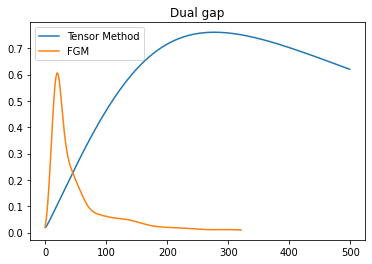

In [18]:
# plt.plot(bdgm_phi_list, label='BDGM')
plt.plot(cr_1_list, label='Tensor Method')
plt.plot(fgm_cr_1_list, label='FGM')
plt.title('Dual gap')
plt.legend()

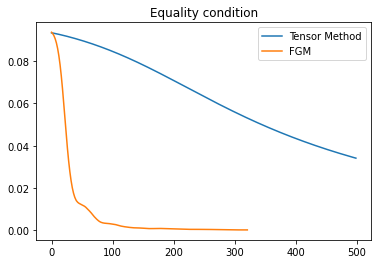

In [19]:
# plt.plot(bdgm_phi_list, label='BDGM')
plt.plot(cr_2_list, label='Tensor Method')
plt.plot(fgm_cr_2_list, label='FGM')
plt.title('Equality condition')
plt.legend()

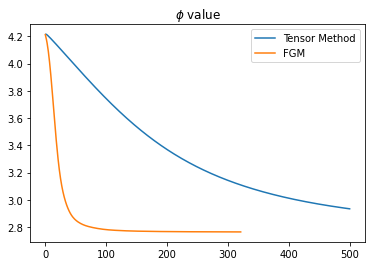

In [20]:
# plt.plot(bdgm_phi_list, label='BDGM')
plt.plot(phi_list, label='Tensor Method')
plt.plot(F_list, label='FGM')
plt.title('$\phi$ value')
plt.legend()

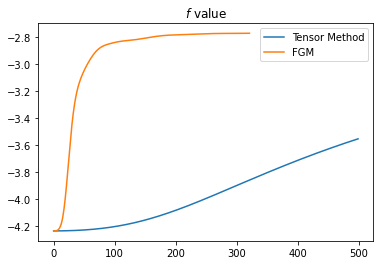

In [21]:
# plt.plot(bdgm_phi_list, label='BDGM')
plt.plot(f_list, label='Tensor Method')
plt.plot(g_list, label='FGM')
plt.title('$f$ value')
plt.legend()

# OT test code from Nazarii

In [16]:
from mnist import MNIST
import numpy as np
from scipy.spatial.distance import cdist
import math
#https://pypi.org/project/python-mnist
mndata = MNIST('./data/')
images, labels = mndata.load_training()
%matplotlib inline
import matplotlib.pyplot as plt
import copy
from numpy import linalg
import time

l = len(images)
n = len(images[0])
m = int(np.sqrt(n))

# def mnist(eps, p, q):
#     p, q = np.float64(images[p]), np.float64(images[q])
#     p, q = p / sum(p), q / sum(q)
    
#     p = (1 - eps / 8) * p + eps / (8 * n)
#     q = (1 - eps / 8) * q + eps / (8 * n)
    
#     return p, q

def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

C = np.arange(m)
C = cartesian_product(C, C)
C = cdist(C, C)
C /= np.max(C)
C.max()

1.0

In [17]:
one = np.ones(n, np.float64)
I = np.ones([n,n], np.float64)
def f_true(x):
    return (C * x).sum()

def B_round(x):
    r = p_ref / x.dot(one)
    r[r>1] = 1.
    F = np.diag(r).dot(x)
    c = q_ref / (x.T).dot(one)
    c[c>1] = 1.
    F = F.dot(np.diag(c))
    err_r = p_ref - F.dot(one)
    err_c = q_ref - (F.T).dot(one)
    return F + np.outer(err_r, err_c) / abs(err_r).sum()

In [18]:
def phi_(gamma, lamu):
    A = (-C/gamma + np.outer(lamu[:n], one) + np.outer(one, lamu[n:]))
    a = A.max()
    A-=a
    s = a+np.log(np.exp(A).sum())
    return gamma*(-lamu[:n].dot(p) - lamu[n:].dot(q) + s)

def f_(gamma, x):
    y = (x.reshape(-1)).copy()
    y[x.reshape(-1) == 0.] = 1.
    
    y = y.reshape(n, -1)
    return (C * x).sum() + gamma * (x * np.log(y)).sum()

In [23]:
def apd(x0, L):
    betta = 0.
    alpha = 0.
    primal_var = 0.*np.ones([n, n], dtype=np.float64)
    z = np.zeros(2*n, dtype=np.float64)
    z_new = np.zeros(2*n, dtype=np.float64)
    eta = np.zeros(2*n, dtype=np.float64)
    eta_new  = np.zeros(2*n, dtype=np.float64)
    grad_phi_new = np.zeros(2*n, dtype=np.float64)
    
    f = lambda x: phi_(gamma, x)
    f_primal = lambda x: f_(gamma, x)
    
    k=0
    start_time = time.perf_counter()
    while True:
        # L = L / 2
        # while True:
        alpha_new = (1 + np.sqrt(4*L*betta + 1)) / 2 / L
        betta_new = betta + alpha_new
        tau = alpha_new / betta_new
        lamu_new = tau * z + (1 - tau) * eta

        logB = (K + np.outer(lamu_new[:n], one) + np.outer(one, lamu_new[n:]))
        max_logB =logB.max()
        logB_stable = logB - max_logB

        B_stable = np.exp(logB_stable)
        u_hat_stable, v_hat_stable = B_stable.dot(one), B_stable.T.dot(one)

        Bs_stable = u_hat_stable.sum()

        phi_new = gamma*(-lamu_new[:n].dot(p) - lamu_new[n:].dot(q) + np.log(Bs_stable) + max_logB)
        grad_phi_new = gamma*np.concatenate((-p + u_hat_stable/Bs_stable, -q + v_hat_stable/Bs_stable),0)

        z_new = z - alpha_new * grad_phi_new
        eta_new = tau * z_new + (1-tau) * eta

        phi_eta = f(eta_new)

            # if phi_eta <= phi_new + grad_phi_new.dot(eta_new - lamu_new) + L * ((eta_new - lamu_new)**2).sum() / 2:
        alpha, betta = alpha_new, betta_new
        z = z_new.copy()
        eta = eta_new.copy()
            #     break    
            # L = L * 2
        primal_var = tau * B_stable/Bs_stable + (1 - tau) * primal_var
        
        cr_1 = abs(f_primal(primal_var) + phi_eta)
        cr_2 = (C * (B_round(primal_var) - primal_var)).sum()
        if k == 0:
            init_cr_1 = cr_1
            init_cr_2 = cr_2

        clear_output(wait=True)
        print('\n'.join([
            f'Step #{k + 1}', 
            f'cr_1: {init_cr_1} -> {cr_1}',
            f'cr_2: {init_cr_2} -> {cr_2}'
        ]))
        if cr_2 <= eps/6 and cr_1 <= eps/6:
            return time.perf_counter() - start_time
        
        k=k+1

In [26]:
x_array = np.linspace(1 / 2e-2, 1 / 4e-4, 6)
epslist = 1 / x_array

In [27]:
epslist

array([0.02      , 0.00185185, 0.00097087, 0.00065789, 0.00049751,
       0.0004    ])

In [ ]:
# if not os.path.isfile('/content/drive/My Drive/colab/'+'!e_'+'apd_'+str(k)+'.npy'):
# i=0
# for eps in epslist:
k = 0
x0 = np.zeros(2 * n, dtype=np.float64)
# epsp = epslist[0] / 8
epsp = eps / 8
p,q = mnist(eps, p_list[k], q_list[k], images, n)
p_ref, q_ref = mnist(0, p_list[k], q_list[k], images, n)
gamma=eps/3/np.log(n)
K=-C/gamma
print(apd(x0, M_1.item()))
# i-=-1
    # np.save('/content/drive/My Drive/colab/'+'!e_'+'apd_'+str(k)+'.npy', y_array)
# print('apd_', k, ' - done', y_array)

# TEST 

In [50]:
def phi_(gamma, lamu):
    A = (-C/gamma + np.outer(lamu[:n], one) + np.outer(one, lamu[n:]))
    a = A.max()
    A-=a
    s = a+np.log(np.exp(A).sum())
    return gamma*(-lamu[:n].dot(p) - lamu[n:].dot(q) + s)

def f_(gamma, x):
    y = (x.reshape(-1)).copy()
    y[x.reshape(-1) == 0.] = 1.
    
    y = y.reshape(n, -1)
    return (M_matrix.numpy() * x).sum() + gamma * (x * np.log(y)).sum()

In [15]:
n 

100